# Importing the libraries

In [1]:
import numpy as np
import pandas as pd
from pandas import DataFrame
from pandas import concat
from pandas import Series
from pandas.plotting import lag_plot

from sklearn.metrics import mean_squared_error, mean_absolute_error
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error
from sklearn.metrics import max_error
from sklearn.metrics import r2_score

from statsmodels.tsa.ar_model import AR
from statsmodels.tsa.arima_model import ARIMA
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.stattools import adfuller
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM, GRU
from keras.layers import Dropout
from numpy.random import seed

import math
from math import sqrt

from matplotlib import pyplot
import matplotlib.pylab as plt
%matplotlib inline
from matplotlib.pylab import rcParams
rcParams['figure.figsize'] = 15, 6

import warnings
warnings.filterwarnings("ignore")

import os
os.environ['KMP_DUPLICATE_LIB_OK']='True' 

# Loading dataset

In [2]:
flight_4 = pd.read_csv("Combined_Data_Apr21.csv")
flight_5 = pd.read_csv("Combined_Data_May21.csv")
flight_6 = pd.read_csv("Combined_Data_Jun21.csv")
flight_4 = flight_4.append(flight_5)
flight_4 = flight_4.append(flight_6)
light = flight_4[["Timestamp", "Num_Flights", "Num_Covid_Cases"]]

In [3]:
data = light.groupby(by=["Timestamp"]).sum()
data.reset_index()
data

,Num_Flights,Num_Covid_Cases
Timestamp,,
2021-04-01,22172,121043182.0
2021-04-02,22133,581019.0
2021-04-03,20228,473933.0
2021-04-04,19946,510425.0
2021-04-05,20539,449404.0
...,...,...
2021-06-26,24179,325744.0
2021-06-27,24558,266822.0
2021-06-28,23978,288210.0


# Visualizing train data

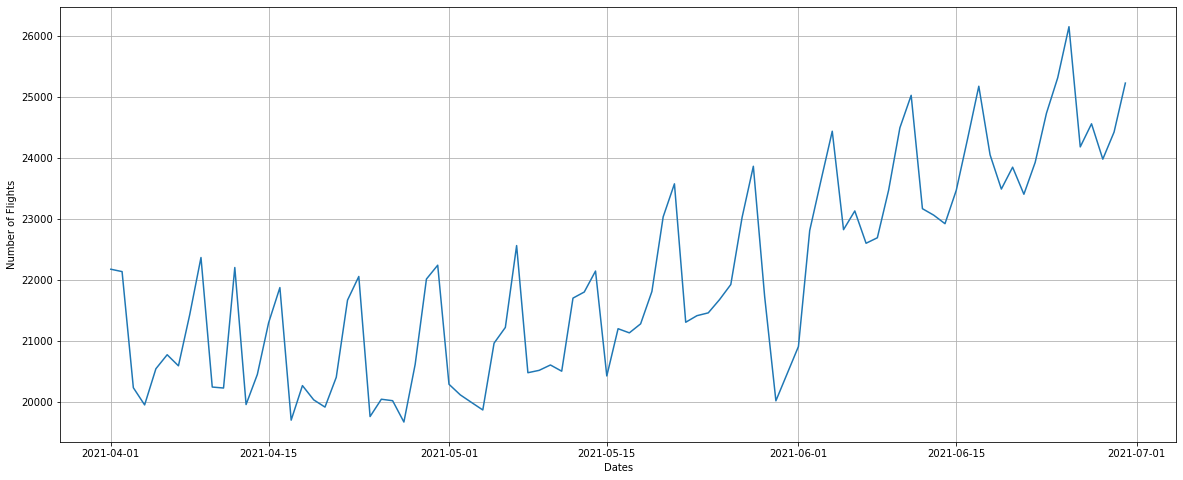

In [4]:
dateparse = lambda dates: pd.datetime.strptime(dates, '%Y-%m-%d')
data = pd.read_csv('data.csv', sep=',', parse_dates=['Timestamp'], index_col='Timestamp',date_parser=dateparse)
plt.figure(figsize=(20,8))
plt.grid(True)
plt.xlabel('Dates')
plt.ylabel('Number of Flights')
plt.plot(data['Num_Flights']);
plt.show()

# Plotting autocorrelation

No handles with labels found to put in legend.


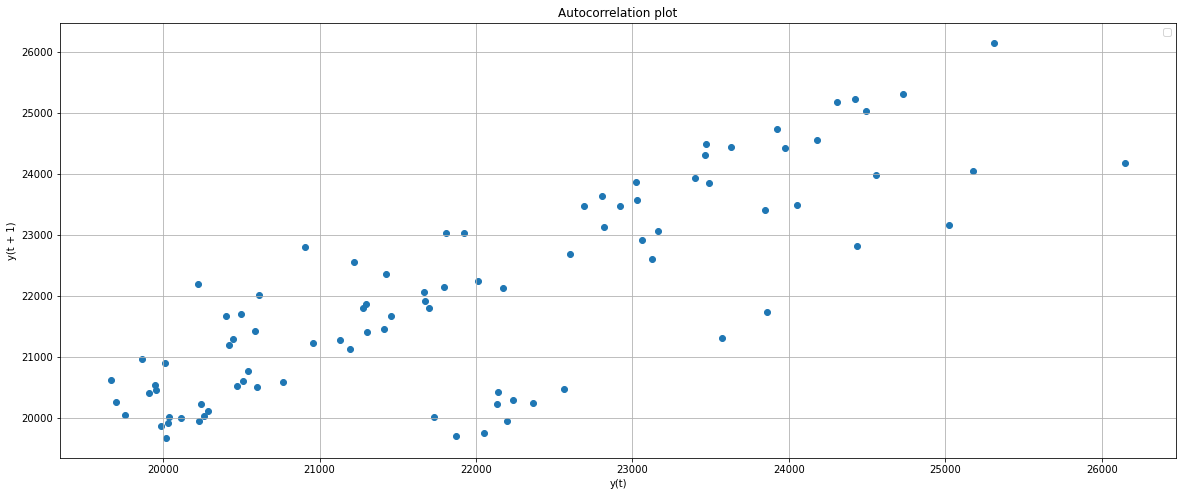

In [5]:
plt.figure(figsize=(20,8))
lag_plot(data['Num_Flights'], lag=1)
plt.title('Autocorrelation plot')
plt.grid(True)
plt.legend();

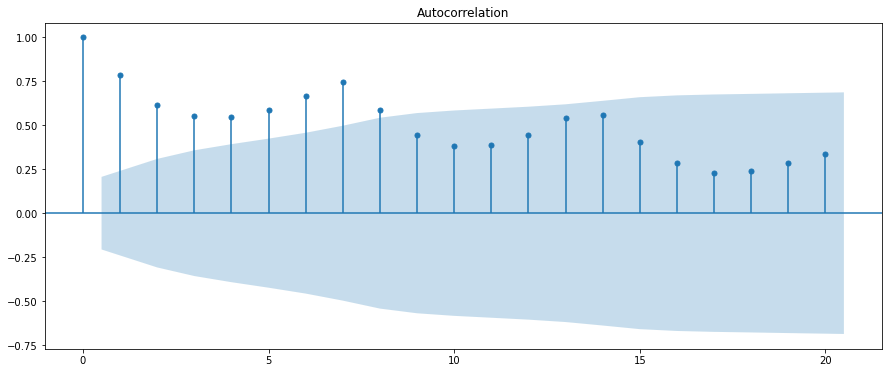

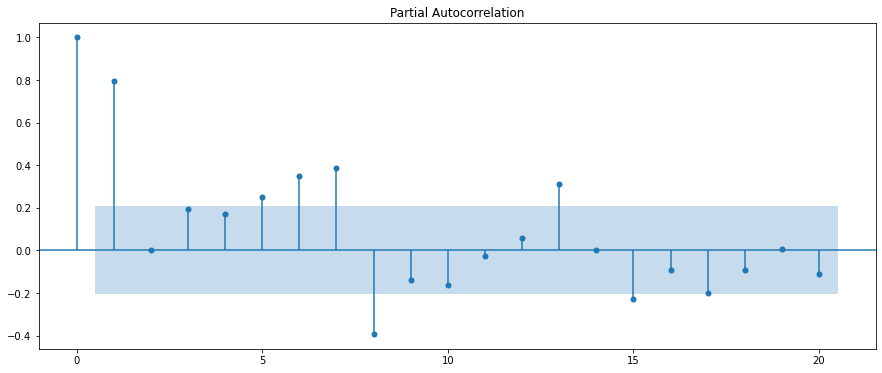

In [6]:
fig1=plot_acf(data['Num_Flights'].dropna()) 
fig2=plot_pacf(data['Num_Flights'].dropna()) 

In [7]:
values = DataFrame(data['Num_Flights'].values)
dataframe = concat([values.shift(120), values], axis=1)
dataframe.columns = ['t-1', 't+1']
result = dataframe.corr()
print(result)

     t-1  t+1
t-1  NaN  NaN
t+1  NaN  1.0


In [8]:
data.tail()

,Num_Flights,Num_Covid_Cases
Timestamp,,
2021-06-26,24179,325744.0
2021-06-27,24558,266822.0
2021-06-28,23978,288210.0
2021-06-29,24422,334241.0
2021-06-30,25226,345862.0


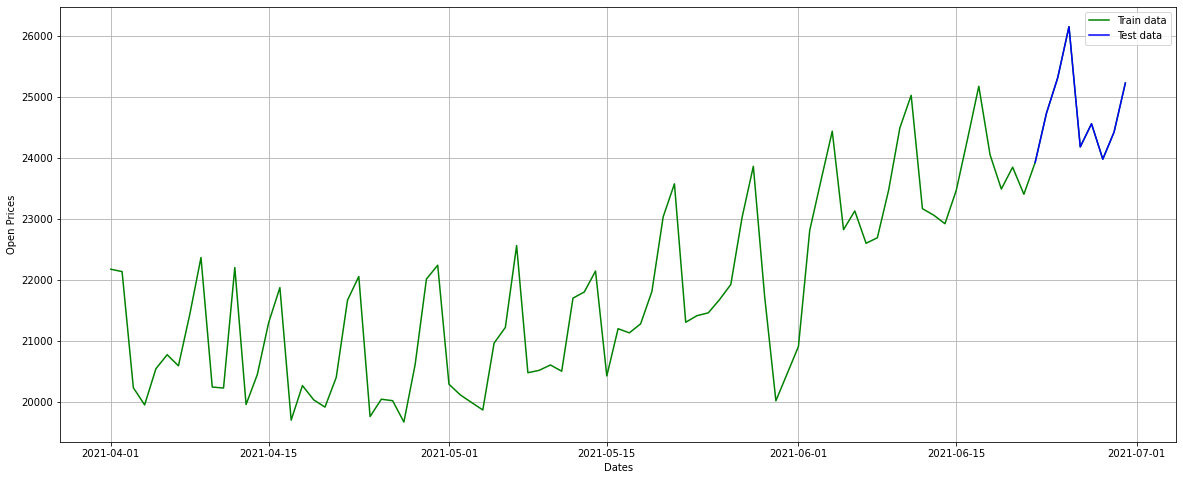

In [9]:
train_data, test_data = data[0:int(len(data)*0.9)], data[int(len(data)*0.9):]
plt.figure(figsize=(20,8))
plt.grid(True)
plt.xlabel('Dates')
plt.ylabel('Open Prices')
plt.plot(data['Num_Flights'], 'green', label='Train data')
plt.plot(test_data['Num_Flights'], 'blue', label='Test data')
plt.legend()

In [10]:
train = train_data.iloc[:, 0:1].values

# Feature Scaling

In [11]:
scaler = MinMaxScaler()
train_scaled = scaler.fit_transform(train) 

In [12]:
timesteps = 7
X_train = []
y_train = []
for i in range(timesteps, train.shape[0]):
    X_train.append(train_scaled[i-timesteps:i, 0])
    y_train.append(train_scaled[i, 0])
X_train, y_train = np.array(X_train), np.array(y_train)

In [13]:
X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], 1))
seed(2019)

# Building the RNN

In [14]:
model = Sequential()

# Adding the first LSTM layer 
# Here return_sequences=True means whether to return the last output in the output sequence, or the full sequence.
# it basically tells us that there is another(or more) LSTM layer ahead in the network.
model.add(LSTM(units = 100, return_sequences = True, input_shape = (X_train.shape[1], 1)))

# Dropout regularisation for tackling overfitting
model.add(Dropout(0.2))

model.add(LSTM(units = 100, return_sequences = True))
model.add(Dropout(0.25))

model.add(LSTM(units = 100, return_sequences = True))
model.add(Dropout(0.2))

model.add(LSTM(units = 100))
model.add(Dropout(0.25))

# Adding the output layer
model.add(Dense(units = 1))

# Compiling the RNN

In [15]:
# RMSprop is a recommended optimizer as per keras documentation
# check out https://keras.io/optimizers/ for more details
model.compile(optimizer = 'adam', loss = 'mean_squared_error')

# Fitting the RNN to the Training set

In [16]:
model.fit(X_train, y_train, epochs = 60, batch_size = 25)

Epoch 1/60
3/3 [==============================] - 4s 17ms/step - loss: 0.1999
Epoch 2/60
3/3 [==============================] - 0s 14ms/step - loss: 0.1229
Epoch 3/60
3/3 [==============================] - 0s 15ms/step - loss: 0.0507
Epoch 4/60
3/3 [==============================] - 0s 13ms/step - loss: 0.0664
Epoch 5/60
3/3 [==============================] - 0s 13ms/step - loss: 0.0426
Epoch 6/60
3/3 [==============================] - 0s 13ms/step - loss: 0.0535
Epoch 7/60
3/3 [==============================] - 0s 16ms/step - loss: 0.0481
Epoch 8/60
3/3 [==============================] - 0s 12ms/step - loss: 0.0384
Epoch 9/60
3/3 [==============================] - 0s 13ms/step - loss: 0.0350
Epoch 10/60
3/3 [==============================] - 0s 13ms/step - loss: 0.0306
Epoch 11/60
3/3 [==============================] - 0s 13ms/step - loss: 0.0268
Epoch 12/60
3/3 [==============================] - 0s 14ms/step - loss: 0.0250
Epoch 13/60
3/3 [==============================] - 0s 13ms/st

In [17]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 7, 100)            40800     
                                                                 
 dropout (Dropout)           (None, 7, 100)            0         
                                                                 
 lstm_1 (LSTM)               (None, 7, 100)            80400     
                                                                 
 dropout_1 (Dropout)         (None, 7, 100)            0         
                                                                 
 lstm_2 (LSTM)               (None, 7, 100)            80400     
                                                                 
 dropout_2 (Dropout)         (None, 7, 100)            0         
                                                                 
 lstm_3 (LSTM)               (None, 100)               8

# Prediction

In [18]:
# Now making the predictions and visualising the results
# this will be used later while comparing and visualization
real = test_data.iloc[:,0:1].values

In [19]:
combine = pd.concat((train_data['Num_Flights'], test_data['Num_Flights']), axis = 0)
test_inputs = combine[len(combine) - len(test_data) - timesteps:].values
test_inputs = test_inputs.reshape(-1,1)
test_inputs = scaler.transform(test_inputs)

In [20]:
test_data.shape

(9, 2)

In [21]:
# same steps as we followed while processing training data
X_test = []
for i in range(timesteps, test_data.shape[0]+timesteps):
    X_test.append(test_inputs[i-timesteps:i, 0])
X_test = np.array(X_test)
X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], 1))
predicted = model.predict(X_test)

# inverse_transform because prediction is done on scaled inputs
predicted = scaler.inverse_transform(predicted)

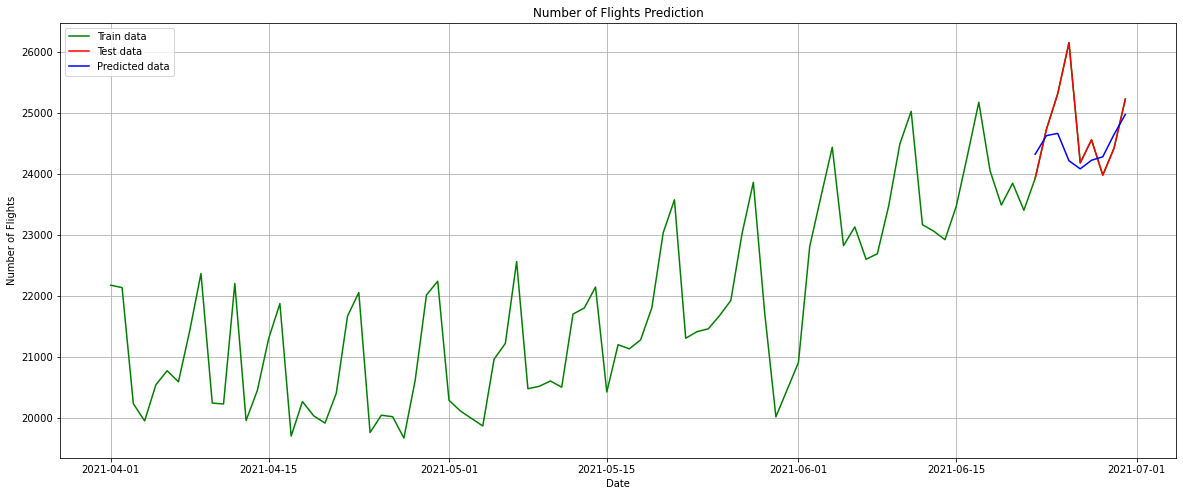

In [22]:
plt.figure(figsize=(20,8))
plt.plot(data.index[-600:], data['Num_Flights'].tail(600), color='green', label = 'Train data')
plt.plot(test_data.index, real, color = 'red', label = 'Test data')
plt.plot(test_data.index, predicted, color = 'blue', label = 'Predicted data')
plt.title('Number of Flights Prediction')
plt.xlabel('Date')
plt.ylabel('Number of Flights')
plt.legend()
plt.grid(True)
plt.savefig('lstm_30.pdf')
plt.show()

# Performance and Evaluation

In [23]:
mse = mean_squared_error(real, predicted)
print('MSE: '+str(mse))
mae = mean_absolute_error(real, predicted)
print('MAE: '+str(mae))
rmse = math.sqrt(mean_squared_error(real, predicted))
print('RMSE: '+str(rmse))
me = max_error(test_data['Num_Flights'], predicted)
print('ME: '+str(me))
score = r2_score(test_data['Num_Flights'], predicted)
print('r2 score: '+str(score))
result = adfuller(data['Num_Flights'])
dict(zip(['adf', 'pvalue', 'usedlag', 'nobs', 'critical' 'values', 'icbest'],result))

MSE: 518960.31842422485
MAE: 477.56792534722223
RMSE: 720.3890049301314
ME: 1937.466796875
r2 score: -0.09963330700372386


{'adf': 2.07303858466979,
 'pvalue': 0.9987606572853565,
 'usedlag': 6,
 'nobs': 83,
 'criticalvalues': {'1%': -3.5117123057187376,
  '5%': -2.8970475206326833,
  '10%': -2.5857126912469153},
 'icbest': 1213.921748359189}